<h1> Experiment 1 </h1>

# Part 1: Pre-training the encoder using SimCLR

set up the environment

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from SimCLR_data_util import preprocess_for_train
from resnet_small import ResNet18
from tensorflow.keras.layers import Dense
from SimCLR import SimCLR

In [2]:
tf.__version__

'2.6.0'

Get the dataset:

In [3]:
from datasets.cifar_10 import get_unsupervised_dataset
dataset = get_unsupervised_dataset(batch_size=64)          # increase batch size if GPU memory available

## Augmentations 
Build the random augmentation layer. In this case, the augmentations are based on a composition of randomly applied crops, collor jitter, reflection, gaussian blur, etc.

In [4]:
class MyAugmentation(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
    
    def call(self, x):
        augment_image = lambda im: preprocess_for_train(im, 32, 32)
        return tf.map_fn(augment_image, x)

augmentation = MyAugmentation()

Here is an example of the original compared to the augmented image

Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.


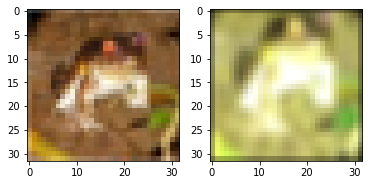

In [5]:
batch = next(iter(dataset))
batch_augmented = augmentation(batch)
fix, (axis1, axis2) = plt.subplots(1, 2)
axis1.imshow(batch[0])
axis2.imshow(batch_augmented[0])

## Encoder 
Build the encoder. We use a ResNet18 backbone, with the final layer removed, and passed through a dense layer onto 2048-dimensional space

In [6]:
def get_encoder():
    model = ResNet18(10)
    encoder = tf.keras.Sequential(model.layers[:-1])
    # encoder = tf.keras.Sequential([
    #     encoder, 
    #     tf.keras.layers.ReLU(), 
    #     tf.keras.layers.Dense(2048)
    # ])
    return encoder

encoder = get_encoder()

Take a look at the encoder network: first, we must build the network by calling it on a batch of data

In [7]:
batch = next(iter(dataset))
output = encoder(batch)
encoder.summary()
print(f'input shape: {batch.shape}')
print(f'output shape: {output.shape}')


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (64, 32, 32, 64)          1728      
_________________________________________________________________
batch_normalization (BatchNo (64, 32, 32, 64)          256       
_________________________________________________________________
sequential_2 (Sequential)    (64, 32, 32, 64)          148480    
_________________________________________________________________
sequential_5 (Sequential)    (64, 16, 16, 128)         526848    
_________________________________________________________________
sequential_8 (Sequential)    (64, 8, 8, 256)           2102272   
_________________________________________________________________
sequential_11 (Sequential)   (64, 4, 4, 512)           8398848   
_________________________________________________________________
flatten (Flatten)            (64, 8192)              

We see that the network maps images of size 32 x 32 x 3 to representations of 8192 dimensions. Our goal is to pretrain this encoder by learning good representations.

## Projection head 

SimCLR requires a projection head which projects the high-dimensional representation onto a lower-dimensional embedding space. Here we use a simple multi-layer perceptron which maps from the 8192-dimensional representation space to a 265-dimensional embedding space: 

In [8]:
def get_projection_head():

    projection_head = tf.keras.Sequential([
        Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        Dense(256)
    ])

    return projection_head

projection_head = get_projection_head()

In [9]:
batch = next(iter(dataset))
output = projection_head(encoder(batch))
projection_head.summary()
print(f'input shape: {batch.shape}')
print(f'output shape: {output.shape}')


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (64, 1024)                8389632   
_________________________________________________________________
dropout (Dropout)            (64, 1024)                0         
_________________________________________________________________
dense_2 (Dense)              (64, 512)                 524800    
_________________________________________________________________
dropout_1 (Dropout)          (64, 512)                 0         
_________________________________________________________________
dense_3 (Dense)              (64, 256)                 131328    
Total params: 9,045,760
Trainable params: 9,045,760
Non-trainable params: 0
_________________________________________________________________
input shape: (64, 32, 32, 3)
output shape: (64, 256)


## Building and training the SimCLR Model

In [10]:
sim_clr_model = SimCLR(encoder, augmentation, projection_head, temperature=0.07)

In [11]:
sim_clr_model(next(iter(dataset)))
sim_clr_model.summary()

Model: "sim_clr"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_12 (Sequential)   (None, 8192)              11178432  
_________________________________________________________________
sequential_13 (Sequential)   (None, 256)               9045760   
_________________________________________________________________
my_augmentation (MyAugmentat multiple                  0         
_________________________________________________________________
sim_clr_logits_from_embeddin multiple                  0         
Total params: 20,224,192
Trainable params: 20,214,592
Non-trainable params: 9,600
_________________________________________________________________


The following cell performs the unsupervised pre-training:

In [12]:
BATCH_SIZE = 256 
EPOCHS = 200     
LEARNING_RATE = 0.0003
SAVE_DIRECTORY = './cifar_10_experiment'

#sim_clr_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
sim_clr_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9))


dataset = get_unsupervised_dataset(batch_size=BATCH_SIZE)  
dataset = dataset.take(len(dataset)-1)

sim_clr_model.fit(dataset, epochs=EPOCHS)

[==============================] - 154s 657ms/step - SimCLR_loss: 0.1467 - SimCLR_accuracy: 0.9846
Epoch 36/200
234/234 [==============================] - 151s 647ms/step - SimCLR_loss: 0.1420 - SimCLR_accuracy: 0.9863
Epoch 37/200
234/234 [==============================] - 153s 653ms/step - SimCLR_loss: 0.1387 - SimCLR_accuracy: 0.9868
Epoch 38/200
234/234 [==============================] - 152s 648ms/step - SimCLR_loss: 0.1374 - SimCLR_accuracy: 0.9864
Epoch 39/200
234/234 [==============================] - 152s 648ms/step - SimCLR_loss: 0.1381 - SimCLR_accuracy: 0.9861
Epoch 40/200
234/234 [==============================] - 152s 648ms/step - SimCLR_loss: 0.1315 - SimCLR_accuracy: 0.9877
Epoch 41/200
234/234 [==============================] - 151s 647ms/step - SimCLR_loss: 0.1327 - SimCLR_accuracy: 0.9872
Epoch 42/200
234/234 [==============================] - 152s 650ms/step - SimCLR_loss: 0.1292 - SimCLR_accuracy: 0.9881
Epoch 43/200
234/234 [==============================] - 151s 

In [21]:
sim_clr_model.save_weights(f'{SAVE_DIRECTORY}/simclr_weights/ckpt2')

In [13]:
BATCH_SIZE = 256 
EPOCHS = 100     
LEARNING_RATE = 0.0001
SAVE_DIRECTORY = './cifar_10_experiment'

sim_clr_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))

dataset = get_unsupervised_dataset(batch_size=BATCH_SIZE)  
dataset = dataset.take(len(dataset)-1)

sim_clr_model.fit(dataset, epochs=EPOCHS)

Epoch 1/100
234/234 [==============================] - 150s 627ms/step - SimCLR_loss: 0.0339 - SimCLR_accuracy: 0.9989
Epoch 2/100
234/234 [==============================] - 147s 628ms/step - SimCLR_loss: 0.0325 - SimCLR_accuracy: 0.9990
Epoch 3/100
234/234 [==============================] - 149s 636ms/step - SimCLR_loss: 0.0329 - SimCLR_accuracy: 0.9989
Epoch 4/100
234/234 [==============================] - 147s 628ms/step - SimCLR_loss: 0.0320 - SimCLR_accuracy: 0.9988
Epoch 5/100
234/234 [==============================] - 151s 643ms/step - SimCLR_loss: 0.0317 - SimCLR_accuracy: 0.9990
Epoch 6/100
234/234 [==============================] - 151s 644ms/step - SimCLR_loss: 0.0319 - SimCLR_accuracy: 0.9989
Epoch 7/100
234/234 [==============================] - 147s 629ms/step - SimCLR_loss: 0.0317 - SimCLR_accuracy: 0.9989
Epoch 8/100
234/234 [==============================] - 149s 636ms/step - SimCLR_loss: 0.0312 - SimCLR_accuracy: 0.9991
Epoch 9/100
234/234 [===========================

In [14]:
encoder = sim_clr_model.encoder

In [15]:
encoder.save_weights(f'{SAVE_DIRECTORY}/encoder_weights/ckpt1')

In [16]:
BATCH_SIZE = 256 
EPOCHS = 3     
LEARNING_RATE = 0.0001
SAVE_DIRECTORY = './cifar_10_experiment'

sim_clr_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))

dataset = get_unsupervised_dataset(batch_size=BATCH_SIZE)  
dataset = dataset.take(len(dataset)-1)

sim_clr_model.fit(dataset, epochs=EPOCHS)

Epoch 1/3
234/234 [==============================] - 149s 622ms/step - SimCLR_loss: 0.0189 - SimCLR_accuracy: 0.9997
Epoch 2/3
234/234 [==============================] - 145s 621ms/step - SimCLR_loss: 0.0190 - SimCLR_accuracy: 0.9997
Epoch 3/3
234/234 [==============================] - 148s 631ms/step - SimCLR_loss: 0.0199 - SimCLR_accuracy: 0.9994


In [17]:
SAVE_DIRECTORY = './cifar_10_experiment'
encoder = get_encoder()
encoder(next(iter(dataset)))
encoder.load_weights(f'{SAVE_DIRECTORY}/encoder_weights/ckpt1')

In [18]:
encoder.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (256, 32, 32, 64)         1728      
_________________________________________________________________
batch_normalization_20 (Batc (256, 32, 32, 64)         256       
_________________________________________________________________
sequential_16 (Sequential)   (256, 32, 32, 64)         148480    
_________________________________________________________________
sequential_19 (Sequential)   (256, 16, 16, 128)        526848    
_________________________________________________________________
sequential_22 (Sequential)   (256, 8, 8, 256)          2102272   
_________________________________________________________________
sequential_25 (Sequential)   (256, 4, 4, 512)          8398848   
_________________________________________________________________
flatten_1 (Flatten)          (256, 8192)             

In [19]:
sim_clr_model = SimCLR(encoder, augmentation, projection_head)
BATCH_SIZE = 256 
EPOCHS = 100     
LEARNING_RATE = 0.0001
SAVE_DIRECTORY = './cifar_10_experiment'

sim_clr_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))

dataset = get_unsupervised_dataset(batch_size=BATCH_SIZE)  
dataset = dataset.take(len(dataset)-1)

sim_clr_model.fit(dataset, epochs=EPOCHS)


Epoch 1/100
234/234 [==============================] - 151s 630ms/step - SimCLR_loss: 5.3439 - SimCLR_accuracy: 0.9990
Epoch 2/100
234/234 [==============================] - 150s 640ms/step - SimCLR_loss: 5.3352 - SimCLR_accuracy: 0.9981
Epoch 3/100
234/234 [==============================] - 149s 638ms/step - SimCLR_loss: 5.3323 - SimCLR_accuracy: 0.9976
Epoch 4/100
234/234 [==============================] - 148s 632ms/step - SimCLR_loss: 5.3303 - SimCLR_accuracy: 0.9971
Epoch 5/100
234/234 [==============================] - 147s 627ms/step - SimCLR_loss: 5.3295 - SimCLR_accuracy: 0.9964
Epoch 6/100
234/234 [==============================] - 149s 637ms/step - SimCLR_loss: 5.3271 - SimCLR_accuracy: 0.9965
Epoch 7/100
234/234 [==============================] - 147s 628ms/step - SimCLR_loss: 5.3259 - SimCLR_accuracy: 0.9964
Epoch 8/100
234/234 [==============================] - 151s 645ms/step - SimCLR_loss: 5.3253 - SimCLR_accuracy: 0.9962
Epoch 9/100
234/234 [===========================

KeyboardInterrupt: 

In [ ]:
sim_clr_model.save_weights(f'{SAVE_DIRECTORY}/simclr_weights/ckpt1')